In [1]:
#!fsharp
#r "nuget: Microsoft.ML.ImageAnalytics, 1.5.2"
#r "nuget: Microsoft.ML.Vision, 1.5.2"
#r "nuget: SciSharp.TensorFlow.Redist, 2.3.1"
#r "nuget: SixLabors.ImageSharp, 1.0.2"

Installed package SixLabors.ImageSharp version 1.0.2

Installed package Microsoft.ML.ImageAnalytics version 1.5.2

Installed package Microsoft.ML.Vision version 1.5.2

Installed package SciSharp.TensorFlow.Redist version 2.3.1

In [1]:
#!fsharp
open System
open System.IO
open Microsoft.ML
open Microsoft.ML.Vision
open Microsoft.ML.Transforms
open Microsoft.ML.Data
open SixLabors.ImageSharp
open SixLabors.ImageSharp.Processing

In [1]:
#!fsharp
type ImageData =
    { ImagePath: string
      Label: string }

[<CLIMutable>]
type ModelInput =
    { Image: byte[]
      Label: string }

[<CLIMutable>]
type ModelOutput =
    { PredictedLabel: string }

In [1]:
#!fsharp
[<Literal>]
let projectRoot = @"C:\Users\grego\source\repos\IsItKrampus.NET"

let dataDir = Path.Combine(projectRoot, "data")
let prepDir = Path.Combine(dataDir, "prepared")
let workspaceDir = Path.Combine(projectRoot, "workspace")

In [1]:
#!fsharp
let mlContext = MLContext(1)

In [1]:
#!fsharp
let loadImagesFromPreparedDir () =
    File.ReadAllLines (Path.Combine(dataDir, "image_prep.csv"))
    |> Array.skip 1
    |> Array.map (fun line ->
        let parts = line.Split(',')
        (parts.[0], parts.[1], bool.Parse parts.[6]))
    |> Array.filter (fun (_, _, isIncluded) -> isIncluded)
    |> Array.map (fun (fileName, label, _) ->
        { ImagePath = fileName
          Label = label })

In [1]:
#!fsharp
let imageData = mlContext.Data.LoadFromEnumerable(loadImagesFromPreparedDir())
let shuffledData = mlContext.Data.ShuffleRows(imageData)

In [1]:
#!fsharp
let preprocessingPipeline =
    EstimatorChain()
        .Append(mlContext.Transforms
            .LoadRawImageBytes(outputColumnName = "Image",
                               imageFolder = prepDir,
                               inputColumnName = "ImagePath"))

In [1]:
#!fsharp
let preProcessedData =
    preprocessingPipeline.Fit(shuffledData)
        .Transform(shuffledData)

In [1]:
#!fsharp
let trainSplit = mlContext.Data.TrainTestSplit(data = preProcessedData, testFraction = 0.3)
let validationTestSplit = mlContext.Data.TrainTestSplit(trainSplit.TestSet)

let trainSet = trainSplit.TrainSet;
let validationSet = validationTestSplit.TrainSet
let testSet = validationTestSplit.TestSet

In [1]:
#!fsharp
let imageClassifierOptions =
    ImageClassificationTrainer.Options(FeatureColumnName = "Image",
                                       LabelColumnName = "LabelAsKey",
                                       ValidationSet = validationSet,
                                       Arch = ImageClassificationTrainer.Architecture.InceptionV3,
                                       TestOnTrainSet = false,
                                       ReuseTrainSetBottleneckCachedValues = true,
                                       ReuseValidationSetBottleneckCachedValues = true,
                                       MetricsCallback = (fun metrics -> display $"%A{metrics}" |> ignore),
                                       WorkspacePath = workspaceDir)

In [1]:
#!fsharp
let trainingPipeline =
    EstimatorChain()
        .Append(mlContext.Transforms.Conversion.MapValueToKey(inputColumnName = "Label",
                                                              outputColumnName = "LabelAsKey"))
        .Append(mlContext.MulticlassClassification.Trainers.ImageClassification(imageClassifierOptions))
        .Append(mlContext.Transforms.Conversion.MapKeyToValue("PredictedLabel", "PredictedLabel"))

In [1]:
#!fsharp
let trainedModel = trainingPipeline.Fit trainSet

Saver not created because there are no variables in the graph to restore


Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:   0, Accuracy:      0,975, Cross-Entropy: 0,19896469

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:   1, Accuracy:      0,975, Cross-Entropy:  0,1409826

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:   2, Accuracy:      0,975, Cross-Entropy: 0,12082022

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:   3, Accuracy:      0,975, Cross-Entropy: 0,108920194

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:   4, Accuracy:      0,975, Cross-Entropy: 0,10130601

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:   5, Accuracy:      0,975, Cross-Entropy: 0,095598795

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:   6, Accuracy:      0,975, Cross-Entropy: 0,091386385

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:   7, Accuracy:      0,975, Cross-Entropy: 0,08791892

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:   8, Accuracy:      0,975, Cross-Entropy: 0,08517941

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:   9, Accuracy:      0,975, Cross-Entropy: 0,08280762

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:  10, Accuracy:      0,975, Cross-Entropy: 0,080857515

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:  11, Accuracy:      0,975, Cross-Entropy: 0,07911514

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:  12, Accuracy:      0,975, Cross-Entropy: 0,07764451

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:  13, Accuracy:      0,975, Cross-Entropy: 0,07630203

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:  14, Accuracy:      0,975, Cross-Entropy:  0,0751478

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:  15, Accuracy:      0,975, Cross-Entropy: 0,074077636

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:  16, Accuracy:      0,975, Cross-Entropy: 0,07314487

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:  17, Accuracy:      0,975, Cross-Entropy: 0,07226981

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:  18, Accuracy:      0,975, Cross-Entropy: 0,07149904

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:  19, Accuracy:      0,975, Cross-Entropy: 0,07076931

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:  20, Accuracy:      0,975, Cross-Entropy: 0,07012116

Saver not created because there are no variables in the graph to restore


Restoring parameters from C:\Users\grego\source\repos\IsItKrampus.NET\workspace\custom_retrained_model_based_on_inception_v3.meta


Froze 2 variables.


Converted 2 variables to const ops.


In [1]:
#!fsharp
let predictions = trainedModel.Transform testSet

In [1]:
#!fsharp
let metrics = mlContext.MulticlassClassification.Evaluate(predictions, labelColumnName = "LabelAsKey")

In [1]:
#!fsharp
display $"Macro Accuracy: %f{metrics.MacroAccuracy} Log Loss: %f{metrics.LogLoss}"

Macro Accuracy: 1.000000 Log Loss: 0.015156

In [1]:
#!fsharp
metrics

LogLoss,LogLossReduction,MacroAccuracy,MicroAccuracy,TopKAccuracy,TopKPredictionCount,PerClassLogLoss,ConfusionMatrix
0.015156306931909908,0.9854227141007618,1,1,0,0,"[ 0.029577204693467495, 0.0006360049540991499, 0.0008348133866054923 ]",Microsoft.ML.Data.ConfusionMatrix


In [1]:
#!fsharp
let modelDir = @"C:\Users\grego\source\repos\IsItKrampus.NET\models"
let modelPath = Path.Combine(modelDir, "model.zip")
mlContext.Model.Save(trainedModel, preProcessedData.Schema, modelPath)

In [1]:
#!fsharp
let mutable predictionPipelineSchema : DataViewSchema = null
let loadedModel = mlContext.Model.Load(modelPath, &predictionPipelineSchema)

In [1]:
#!fsharp
let predictionEngine = mlContext.Model.CreatePredictionEngine<ModelInput, ModelOutput>(loadedModel)


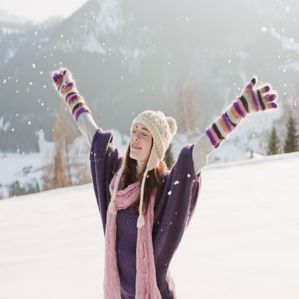

In [1]:
#!fsharp
let image =
    @"C:\Users\grego\source\repos\IsItKrampus.NET\data\prepared\d5efde7e-7eb6-4564-a385-80533e5363d5.jpg"
    |> File.ReadAllBytes

let base64 = Convert.ToBase64String image

DisplayFunctions.HTML $"<img src=\"data:image/png;base64,{base64}\"></img>"

In [1]:
#!fsharp
let input : ModelInput =
    { Image = image
      Label = null }

let output = predictionEngine.Predict input

output

PredictedLabel
Other
